In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dataclasses
import math
from pycpd import RigidRegistration
from typing import Tuple, Iterable

In [2]:
# Параметры карты и параметры сканирования робота
MAP_SIZE = 15
LIDAR_ANGLE_STEP = 5 # Шаг лидара
LIDAR_ANGLE_RANGE = 360 # Область сканирования лидара в градусах
LIDAR_MAX_DISTANCE = 999 # Максимальная дистанция лидара

In [3]:
@dataclasses.dataclass
class RobotPose:
    x: float
    y: float
    theta: float  # в радианах

@dataclasses.dataclass
class Room:
    map_as_2d_array: np.ndarray
    map_size: int
    obstacle_positions: Iterable[Tuple[float, float]]

@dataclasses.dataclass
class Transformation:
    s: float # Scale factor
    R: np.array # Rotation matrix
    t: Tuple[float, float] # Translation vector

@dataclasses.dataclass
class RoomTestSetup:
    obstacle_positions: Iterable[Tuple[float, float]]
    robot_positions: Iterable[Tuple[RobotPose, RobotPose]]

In [4]:
# Расположение объектов на карте и робота

# ROOM 1 - Комната со срезанным углом
obstacle_positions1 = [(1,5),(2,4),(3,3),(4,2),(5,1), (3 ,2), (4,1), (1,4), (2,3)]

# ROOM 1 - SETUP 1
# Стоим в разных серединах комнаты
# - - - - - - - - - - - -
# -                     -
# -                     -
# -     1               -
# -                     -
# -*                    -
# - *                   -
# -  *          2       -
# -   *                 -
# -    *                -
# - - - - - - - - - - - -
pose_r1_s1_1 = RobotPose(x=4,y=9,theta=0)
pose_r1_s1_2 = RobotPose(x=10, y=5, theta=0)

# ROOM 1 - SETUP 2
# В дальнем углу от серезанного угла, чуть пододвинулись к срезанному
# - - - - - - - - - - - -
# -                     -
# -               1     -
# -                     -
# -             2       -
# -*                    -
# - *                   -
# -  *                  -
# -   *                 -
# -    *                -
# - - - - - - - - - - - -
pose_r1_s2_1 = RobotPose(x=12,y=12,theta=0)
pose_r1_s2_2 = RobotPose(x=10, y=10, theta=0)

# ROOM 1 - SETUP 3
# В центре комнаты поворачиваемся на 30 градусов
# - - - - - - - - - - - -
# -                     -
# -                     -
# -               2     -
# -            /        -
# -*         0 -> 1     -
# - *                   -
# -  *                  -
# -   *                 -
# -    *                -
# - - - - - - - - - - - -
pose_r1_s3_1 = RobotPose(x=7, y=7, theta=0)
pose_r1_s3_2 = RobotPose(x=7, y=7, theta=math.radians(30))

# ROOM 1 - SETUP 4
# Одновременно сдвинули и повернулись
pose_r1_s4_1 = RobotPose(x=7, y=7, theta=0)
pose_r1_s4_2 = RobotPose(x=8, y=8, theta=math.radians(30))

# ROOM 1 - SETUP 5
# 180 градусов поворот - смееерть ☠️
pose_r1_s5_1 = RobotPose(x=7, y=7, theta=0)
pose_r1_s5_2 = RobotPose(x=7, y=7, theta=math.radians(180))

room_test_setup1 = RoomTestSetup(
    obstacle_positions=obstacle_positions1,
    robot_positions=[
        (pose_r1_s1_1, pose_r1_s1_2),
        (pose_r1_s2_1, pose_r1_s2_2),
        (pose_r1_s3_1, pose_r1_s3_2),
        (pose_r1_s4_1, pose_r1_s4_2),
        (pose_r1_s5_1, pose_r1_s5_2),
    ]
)
# ROOM 2 - Комната с колоннами
obstacle_positions2 = [(3, 7),(8, 7)]


# ROOM 2 - SETUP 1
# Уехали назад к стене от колонн
pose_r2_s1_1 = RobotPose(x=6, y=3, theta=0)
pose_r2_s1_2 = RobotPose(x=6, y=1, theta=0)

# ROOM 2 - SETUP 2
# Сканируем с другой стороны комнаты - смееерть ☠️
pose_r2_s2_1 = RobotPose(x=3, y=3, theta=0)
pose_r2_s2_2 = RobotPose(x=8, y=3, theta=0)

# ROOM 2 - SETUP 3
# Поворот из одной точки
pose_r2_s3_1 = RobotPose(x=5, y=3, theta=math.radians(45))
pose_r2_s3_2 = RobotPose(x=5, y=3, theta=math.radians(135))

# ROOM 2 - SETUP 4
# Поворот + немного движения
pose_r2_s4_1 = RobotPose(x=5, y=3, theta=0)
pose_r2_s4_2 = RobotPose(x=6, y=3, theta=math.radians(30))

# ROOM 2 - SETUP 5
# Сканируем с другой стороны комнаты 2 - смееерть ☠️
pose_r2_s5_1 = RobotPose(x=5, y=3, theta=0)
pose_r2_s5_2 = RobotPose(x=10, y=11, theta=0)

room_test_setup2 = RoomTestSetup(
    obstacle_positions=obstacle_positions2,
    robot_positions=[
        (pose_r2_s1_1, pose_r2_s1_2),
        (pose_r2_s2_1, pose_r2_s2_2),
        (pose_r2_s3_1, pose_r2_s3_2),
        (pose_r2_s4_1, pose_r2_s4_2),
        (pose_r2_s5_1, pose_r2_s5_2),
    ]
)
# ROOM 3 - Т-образный коридор
obstacle_positions3 = [
    (9,1), (5,1),(9,2), (5,2),(9,3), (5,3),(9,4), (5,4),(9,5), (5,5), (1,5),(2,5),(3,5),(4,5),(5,5),(10,5),(11,5),(12,5),(13,5),(14,5),
    *[(i, 10) for i in range(1, MAP_SIZE)],
]

# ROOM 3 - SETUP 1
# Проезд по коридору
pose_r3_s1_1 = RobotPose(x=5, y=7, theta=0)
pose_r3_s1_2 = RobotPose(x=7, y=7, theta=0)

# ROOM 3 - SETUP 2
# Разные концы коридора - смееерть ☠️
pose_r3_s2_1 = RobotPose(x=3, y=7, theta=0)
pose_r3_s2_2 = RobotPose(x=11, y=7, theta=0)

# ROOM 3 - SETUP 3
# Поворот в центре коридора
pose_r3_s3_1 = RobotPose(x=7, y=7, theta=math.radians(0))
pose_r3_s3_2 = RobotPose(x=7, y=7, theta=math.radians(60))

# ROOM 3 - SETUP 4
# Поворот в центре коридора и проезд немного
pose_r3_s4_1 = RobotPose(x=7, y=7, theta=math.radians(0))
pose_r3_s4_2 = RobotPose(x=7, y=8, theta=math.radians(60))

room_test_setup3 = RoomTestSetup(
    obstacle_positions=obstacle_positions3,
    robot_positions=[
        (pose_r3_s1_1, pose_r3_s1_2),
        (pose_r3_s2_1, pose_r3_s2_2),
        (pose_r3_s3_1, pose_r3_s3_2),
        (pose_r3_s4_1, pose_r3_s4_2),
    ]
)

# ROOM 4 - Стена в комнате
obstacle_positions4 = [
    *[(i, MAP_SIZE - 5) for i in range(3, MAP_SIZE - 3)],
]

# ROOM 4 - SETUP 1
# Подъезд к стене по диагонали
pose_r4_s1_1 = RobotPose(x=3, y=3, theta=0)
pose_r4_s1_2 = RobotPose(x=5, y=5, theta=0)

# ROOM 4 - SETUP 2
# Проезд вдоль нижней стены
pose_r4_s2_1 = RobotPose(x=3, y=3, theta=0)
pose_r4_s2_2 = RobotPose(x=8, y=3, theta=0)

# ROOM 4 - SETUP 3
# Отрицательный угол
pose_r4_s3_1 = RobotPose(x=5, y=5, theta=math.radians(60))
pose_r4_s3_2 = RobotPose(x=5, y=5, theta=math.radians(30))

# ROOM 4 - SETUP 4
# положительный угол
pose_r4_s4_1 = RobotPose(x=5, y=5, theta=math.radians(30))
pose_r4_s4_2 = RobotPose(x=5, y=5, theta=math.radians(60))


room_test_setup4 = RoomTestSetup(
    obstacle_positions=obstacle_positions4,
    robot_positions=[
        (pose_r4_s1_1, pose_r4_s1_2),
        (pose_r4_s2_1, pose_r4_s2_2),
        (pose_r4_s3_1, pose_r4_s3_2),
        (pose_r4_s4_1, pose_r4_s4_2),
    ]
)


In [5]:
from typing import Iterable, Tuple


def make_room(
    room_size: int, 
    obstacle_positions: Iterable[Tuple[int, int]],
    robot_pose: RobotPose,
) -> Room:
    """Делает комнату с занятыми точками"""
    room = np.zeros((room_size, room_size))
    # Отмечаем каждую колонну
    for obstacle_position in obstacle_positions:
        room[obstacle_position[::-1]] = 1

    # Определеяем стены комнаты
    for i in range(room_size):
        room[(0, i)] = 1
        room[(i, 0)] = 1
        room[(i, room_size - 1)] = 1
        room[(room_size - 1, i)] = 1

    # Размещаем робота
    room[(robot_pose.x, robot_pose.y)[::-1]] = 0.5  # 0.5 определяет робота
    
    return Room(map_as_2d_array=room, map_size=room_size, obstacle_positions=obstacle_positions)

def laser_scan_with_distances(pos: RobotPose, room, step=LIDAR_ANGLE_STEP, max_distance=LIDAR_MAX_DISTANCE) -> (np.ndarray, np.ndarray):
    """
    Функция осуществляет лазерное сканирование (aka LIDAR)
    Возвращает отсканированные расстояния (-1 - дальше чем макс. дистанция) и углы
    """
    degress_start = math.degrees(pos.theta)
    angles = np.arange(degress_start, degress_start + LIDAR_ANGLE_RANGE, step) % 360
    scan_distances = []

    for angle in angles:
        rad = np.radians(angle)
        distance = -1  # По умолчанию -1 если препятствие не обнаружено
        for r in range(1, max_distance):
            x = int(pos.x + r * np.cos(rad))
            y = int(pos.y + r * np.sin(rad))

            # Проверяем стены и препятствия
            if x < 0 or y < 0 or x >= MAP_SIZE or y >= MAP_SIZE or room[y, x] == 1:
                distance = r
                break

        scan_distances.append(distance)

    return np.array(scan_distances), angles

def visualize_scan_result(pose: RobotPose, scan_distances, angles, room, obstacle_positions) -> None:
    """Визуализирует карту, робота, препятствия и результаты сканирования"""
    plt.figure(figsize=(6, 6))
    plt.imshow(room, cmap='Greys', origin='lower')
    plt.scatter(*zip(*obstacle_positions), color='red', label='Препятствия')
    plt.scatter(pose.x, pose.y, color='blue', label='Робот', s=100)
    
    angles = np.radians(angles)

    # Рисуем линии на каждый выпущенный луч скана
    for i, (angle, distance) in enumerate(zip(angles, scan_distances)):
        if distance != -1:  # Проверяем было ли препятствие
            end_point = (pose.x + distance * np.cos(angle), pose.y + distance * np.sin(angle))
            color = 'orange' if i == 0 else 'green' # Первый луч - угол робота - другим цветом
            linewidth = 2.0 if i == 0 else 0.5
            plt.plot([pose.x, end_point[0]], [pose.y, end_point[1]], color=color, linewidth=linewidth)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Карта с роботом и результатом сканирования')
    plt.legend()
    plt.grid(True)
    plt.show()

def scan_to_point_cloud(scan_distances, angles):
    """
    Преобразует расстояния скана в облако точек
    Робот находится в точке (0, 0) с углом 0 радиан
    """
    angles_rad = np.radians(np.arange(0, LIDAR_ANGLE_RANGE, LIDAR_ANGLE_STEP))
    
    # Фильтруем точки, где скан ушел за максимальное расстояние
    valid_distances = scan_distances[scan_distances > 0]
    valid_angles_rad = angles_rad[scan_distances > 0]

    x_coords = valid_distances * np.cos(valid_angles_rad)
    y_coords = valid_distances * np.sin(valid_angles_rad)
    
    return np.column_stack((x_coords, y_coords))

def plot_point_clouds(A, B, transformed_A=None):
    """
    Представляет два облака точек на одном графике
    """
    plt.figure(figsize=(6, 6))

    plt.scatter(A[:, 0], A[:, 1], color='red', marker='^', label='Облако точек 1')

    plt.scatter(B[:, 0], B[:, 1], color='blue', marker='o', label='Облако точек 2')

    if transformed_A is not None:
        plt.scatter(transformed_A[:, 0], transformed_A[:, 1], color='green', marker='x', label='Трансформированое облако точек 1')

    
    plt.title("Визуализация облаков точек")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

def pycpd_get_transformed_point_cloud(point_cloud1, point_cloud2) -> [np.array, Transformation]:
    """
    Определяем трансформацию между двумя облаками точек с помощью 
    CPD (Coherent Point Drift)

    Возвращаем трансформированное облако и параметры трансформации
    """
    reg = RigidRegistration(X=point_cloud2, Y=point_cloud1)  # (X=target, Y=source)
    TY, (s_reg, R_reg, t_reg) = reg.register()  # returns s - scale, R - rotation matrix, t - translation vector
    return reg.transform_point_cloud(Y=point_cloud1), Transformation(s=s_reg, R=R_reg, t=t_reg)

def show_scan_matching_summary(pose1: RobotPose, pose2: RobotPose, transformation: Transformation) -> None:    
    ROUND_DECIMALS = 3

    cos_theta = np.round(transformation.R[0,0], 5) # чтобы 1.0000000007 не ломала math.acos
    if transformation.R[0,1] < 0:
        estimated_theta_sign = 1
    elif transformation.R[1,0] <= 0:
        estimated_theta_sign = -1

    # Предсказанная по наложению сканов трансформация
    cpd_estimated_theta = math.acos(cos_theta)
    cpd_estimated_theta *= estimated_theta_sign
    cpd_estimated_x = -transformation.t[0]  # почему "-" ??? :)
    cpd_estimated_y = -transformation.t[1]

    # Истиная трансформация
    actual_x_translation = pose2.x - pose1.x
    actual_y_translation = pose2.y - pose1.y
    actual_theta_translation = pose2.theta - pose1.theta

    # Разница трансформаций
    diff_x = actual_x_translation - cpd_estimated_x
    diff_y = actual_y_translation - cpd_estimated_y
    diff_theta = actual_theta_translation - cpd_estimated_theta

    # Округляем, чтобы не смотреть 20 знаков после плавающей точки
    cpd_estimated_theta = np.round(cpd_estimated_theta, ROUND_DECIMALS)
    cpd_estimated_x = np.round(cpd_estimated_x, ROUND_DECIMALS)
    cpd_estimated_y = np.round(cpd_estimated_y, ROUND_DECIMALS)
    actual_x_translation = np.round(actual_x_translation, ROUND_DECIMALS)
    actual_y_translation = np.round(actual_y_translation, ROUND_DECIMALS)
    actual_theta_translation = np.round(actual_theta_translation, ROUND_DECIMALS)
    diff_x = np.round(abs(diff_x), ROUND_DECIMALS)
    diff_y = np.round(abs(diff_y), ROUND_DECIMALS)
    diff_theta = np.round(abs(diff_theta), ROUND_DECIMALS)

    diff_x_from_room = np.round(diff_x / MAP_SIZE * 100, ROUND_DECIMALS)
    diff_y_from_room = np.round(diff_y / MAP_SIZE * 100, ROUND_DECIMALS)
    diff_theta_from_2pi = np.round(diff_theta / math.radians(360) * 100, ROUND_DECIMALS)

    translation_vector_length = round(
        math.sqrt((diff_x)**2 + (diff_y)**2)
        , 3
    )
    room_diagonal_length = MAP_SIZE * math.sqrt(2)
    translation_vector_accuracy = round(translation_vector_length / room_diagonal_length * 100, 3)

    print(f"{MAP_SIZE=} {LIDAR_ANGLE_STEP=} {pose1=} {pose2=}")
    print(f"Точность трансформации ветора X/Y - {translation_vector_accuracy}%")

    print(" -- Истинное преобразвание -- ")
    print(f"\tX\t{actual_x_translation}")
    print(f"\tY\t{actual_y_translation}")
    print(f"\tθ(rad)\t{actual_theta_translation}")

    print(" -- Расчитанное преобразование -- ")
    print(f"\tX\t{cpd_estimated_x}")
    print(f"\tY\t{cpd_estimated_y}")
    print(f"\tθ(rad)\t{cpd_estimated_theta}")

    print(" -- Разница преобразований (% от размера комнаты) -- ")
    print(f"\tX\t{diff_x} ({diff_x_from_room}%)")
    print(f"\tY\t{diff_y} ({diff_y_from_room}%)")
    print(f"\tθ(rad)\t{diff_theta} ({diff_theta_from_2pi}%) (% от 2*Pi)")

        

In [6]:
def conduct_experiment(obstacle_positions, pose1, pose2):
    room = make_room(MAP_SIZE, obstacle_positions, pose1)
    scan_distances, angles = laser_scan_with_distances(pose1, room.map_as_2d_array)
    scan_distances2, angles2 = laser_scan_with_distances(pose2, room.map_as_2d_array)
    point_cloud1 = scan_to_point_cloud(scan_distances, angles)
    point_cloud2 = scan_to_point_cloud(scan_distances2, angles2)
    point_cloud1_transformed, transformation = pycpd_get_transformed_point_cloud(point_cloud1, point_cloud2)
    # print(f"{transformation=}")
    visualize_scan_result(pose1, scan_distances, angles, room.map_as_2d_array, room.obstacle_positions)
    visualize_scan_result(pose2, scan_distances2, angles2, room.map_as_2d_array, room.obstacle_positions)
    plot_point_clouds(point_cloud1, point_cloud2, point_cloud1_transformed)
    show_scan_matching_summary(pose1, pose2, transformation)

  == Комната 1 - Эксперимент 1 ==  


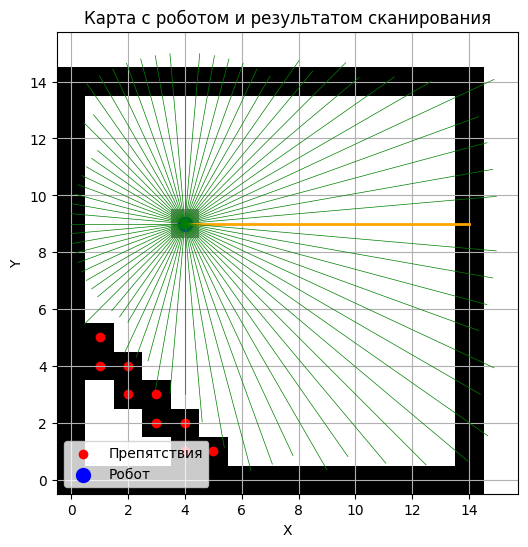

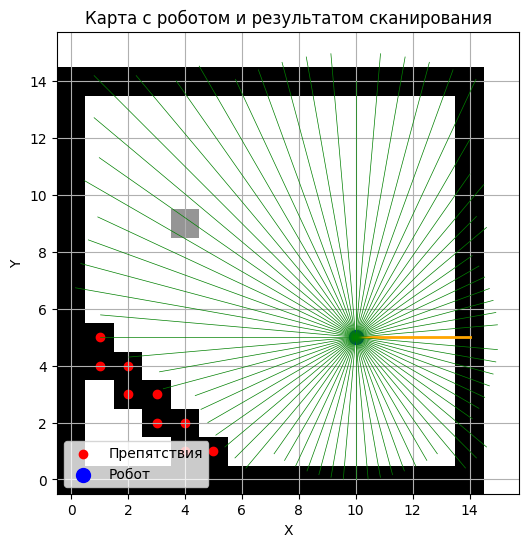

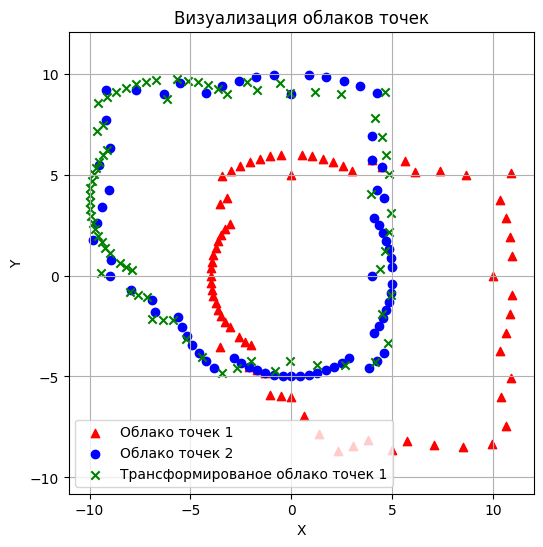

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=4, y=9, theta=0) pose2=RobotPose(x=10, y=5, theta=0)
Точность трансформации ветора X/Y - 1.146%
 -- Истинное преобразвание -- 
	X	6
	Y	-4
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	6.018
	Y	-3.758
	θ(rad)	-0.028
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.018 (0.12%)
	Y	0.242 (1.613%)
	θ(rad)	0.028 (0.446%) (% от 2*Pi)
  == Комната 1 - Эксперимент 2 ==  


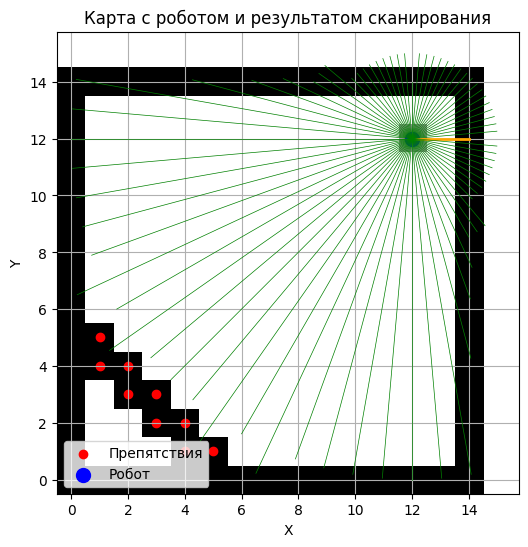

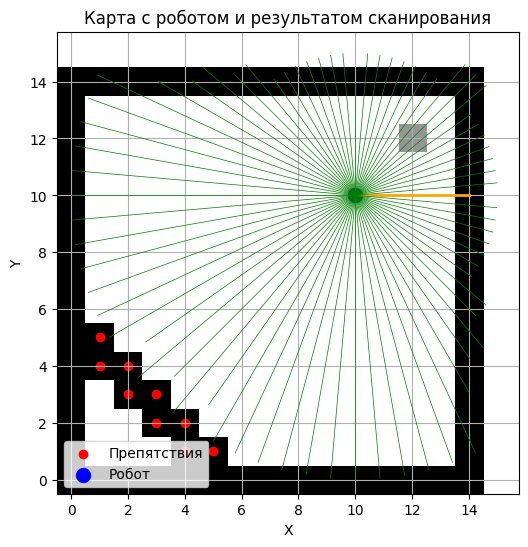

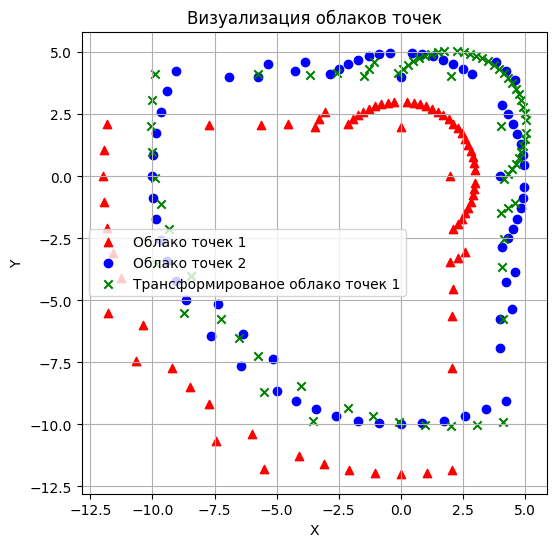

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=12, y=12, theta=0) pose2=RobotPose(x=10, y=10, theta=0)
Точность трансформации ветора X/Y - 0.113%
 -- Истинное преобразвание -- 
	X	-2
	Y	-2
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	-2.017
	Y	-2.017
	θ(rad)	-0.0
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.017 (0.113%)
	Y	0.017 (0.113%)
	θ(rad)	0.0 (0.0%) (% от 2*Pi)
  == Комната 1 - Эксперимент 3 ==  


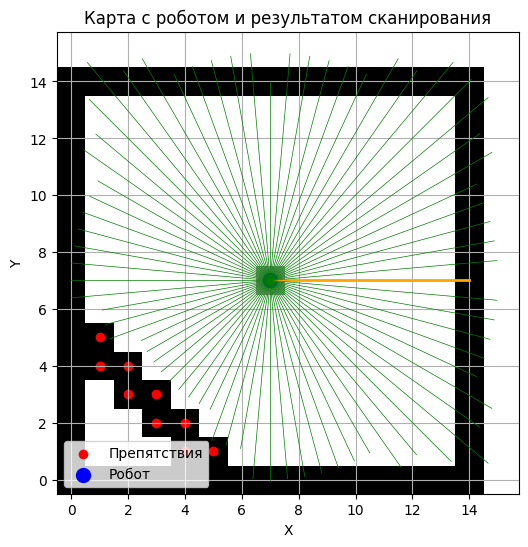

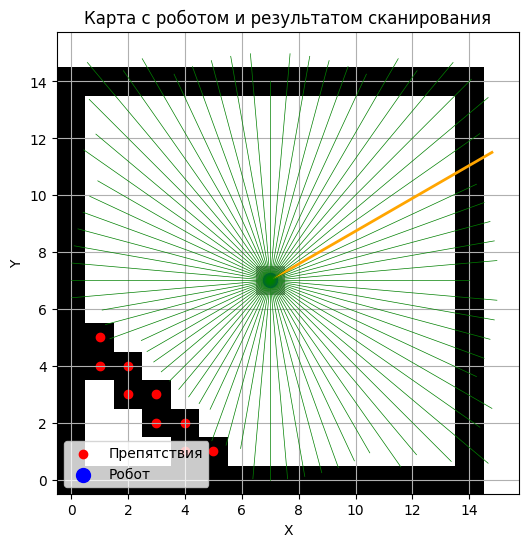

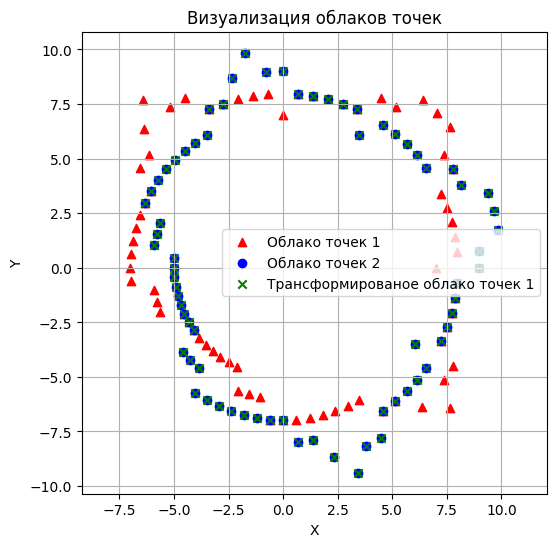

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=7, y=7, theta=0) pose2=RobotPose(x=7, y=7, theta=0.5235987755982988)
Точность трансформации ветора X/Y - 0.0%
 -- Истинное преобразвание -- 
	X	0
	Y	0
	θ(rad)	0.524
 -- Расчитанное преобразование -- 
	X	-0.0
	Y	-0.0
	θ(rad)	0.524
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.0 (0.0%)
	Y	0.0 (0.0%)
	θ(rad)	0.0 (0.0%) (% от 2*Pi)
  == Комната 1 - Эксперимент 4 ==  


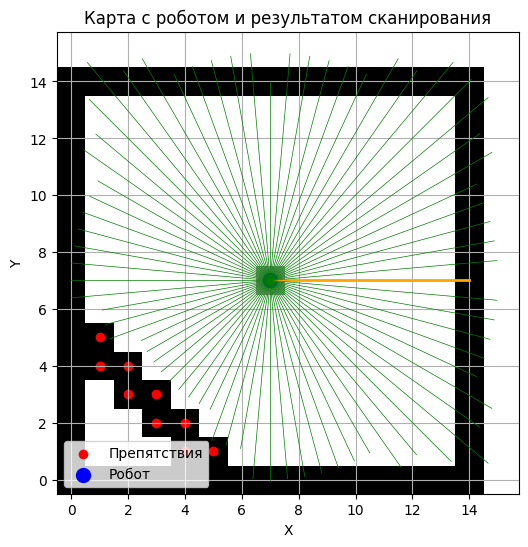

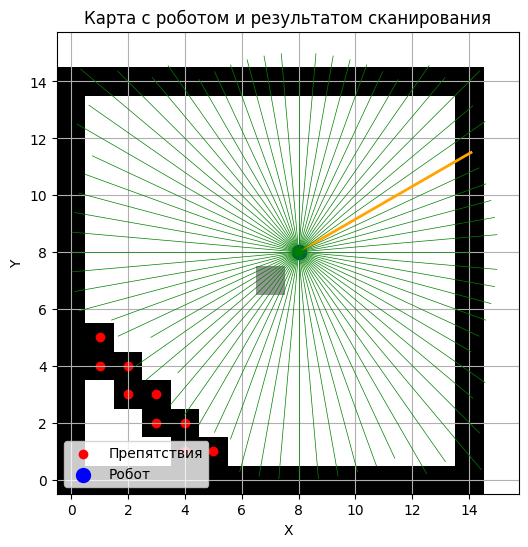

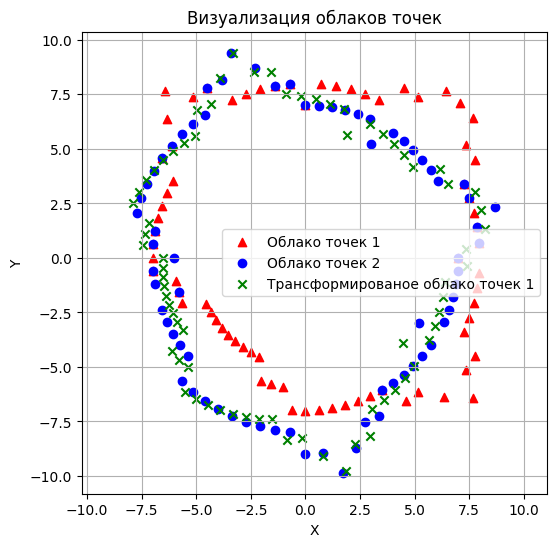

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=7, y=7, theta=0) pose2=RobotPose(x=8, y=8, theta=0.5235987755982988)
Точность трансформации ветора X/Y - 3.771%
 -- Истинное преобразвание -- 
	X	1
	Y	1
	θ(rad)	0.524
 -- Расчитанное преобразование -- 
	X	1.561
	Y	0.43
	θ(rad)	0.52
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.561 (3.74%)
	Y	0.57 (3.8%)
	θ(rad)	0.004 (0.064%) (% от 2*Pi)
  == Комната 1 - Эксперимент 5 ==  


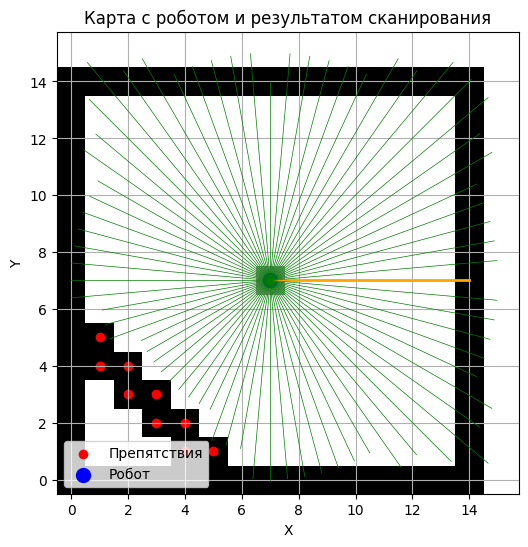

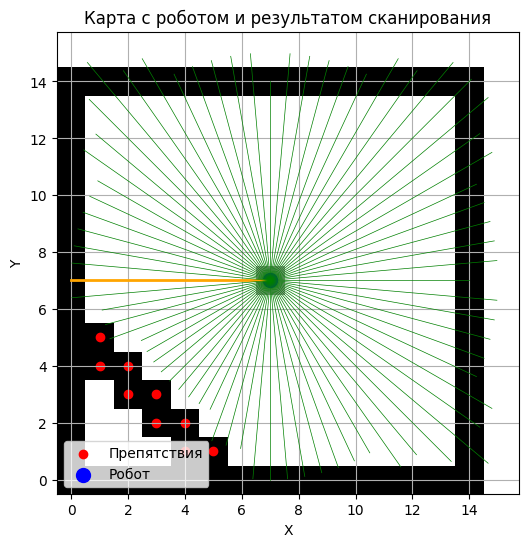

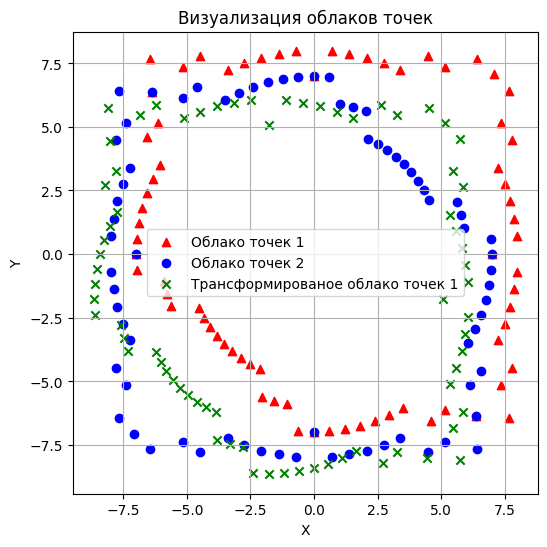

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=7, y=7, theta=0) pose2=RobotPose(x=7, y=7, theta=3.141592653589793)
Точность трансформации ветора X/Y - 11.879%
 -- Истинное преобразвание -- 
	X	0
	Y	0
	θ(rad)	3.142
 -- Расчитанное преобразование -- 
	X	1.782
	Y	1.782
	θ(rad)	0.0
 -- Разница преобразований (% от размера комнаты) -- 
	X	1.782 (11.88%)
	Y	1.782 (11.88%)
	θ(rad)	3.142 (50.006%) (% от 2*Pi)


In [7]:
for i, (pose1, pose2) in enumerate(room_test_setup1.robot_positions, start=1):
    print(f"  == Комната 1 - Эксперимент {i} ==  ")
    conduct_experiment(room_test_setup1.obstacle_positions, pose1, pose2)


  == Комната 2 - Эксперимент 1 ==  


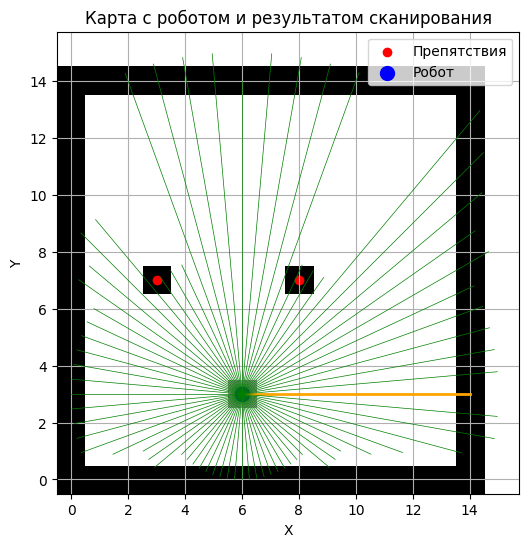

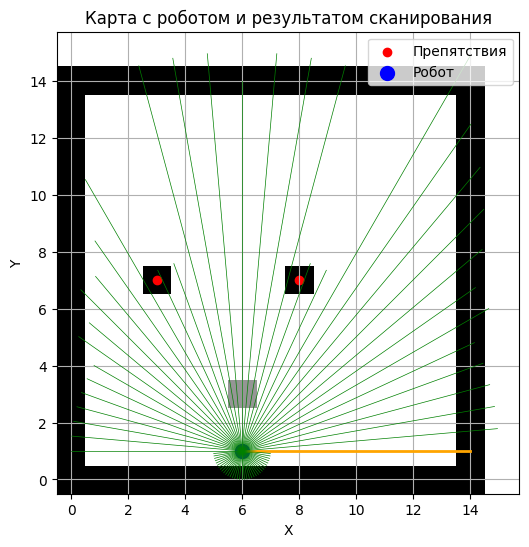

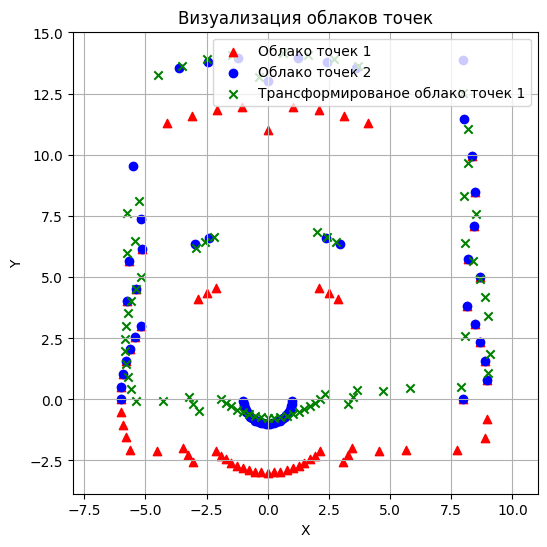

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=6, y=3, theta=0) pose2=RobotPose(x=6, y=1, theta=0)
Точность трансформации ветора X/Y - 1.235%
 -- Истинное преобразвание -- 
	X	0
	Y	-2
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	-0.122
	Y	-2.232
	θ(rad)	-0.045
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.122 (0.813%)
	Y	0.232 (1.547%)
	θ(rad)	0.045 (0.716%) (% от 2*Pi)
  == Комната 2 - Эксперимент 2 ==  


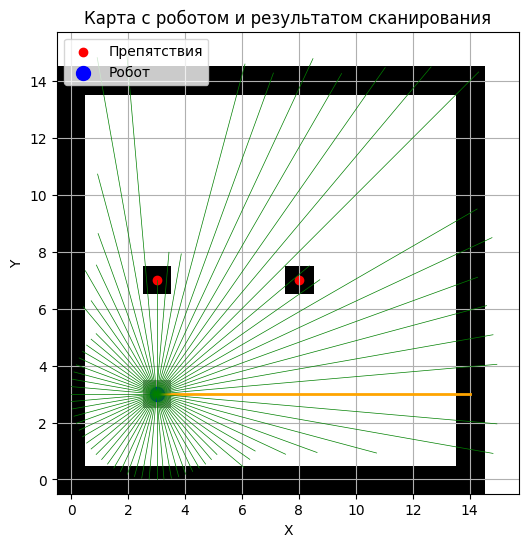

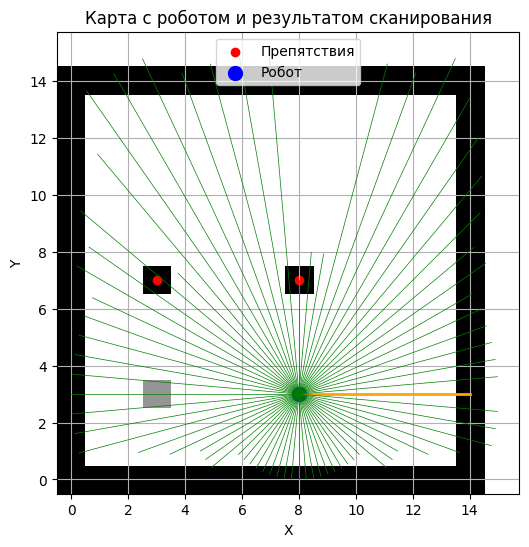

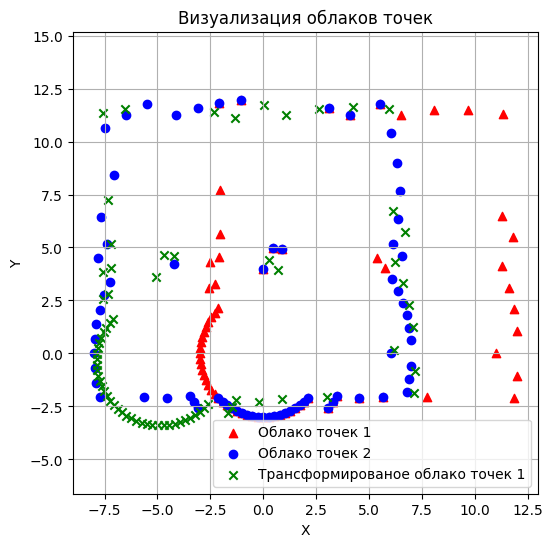

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=3, y=3, theta=0) pose2=RobotPose(x=8, y=3, theta=0)
Точность трансформации ветора X/Y - 1.923%
 -- Истинное преобразвание -- 
	X	5
	Y	0
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	4.862
	Y	0.384
	θ(rad)	-0.05
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.138 (0.92%)
	Y	0.384 (2.56%)
	θ(rad)	0.05 (0.796%) (% от 2*Pi)
  == Комната 2 - Эксперимент 3 ==  


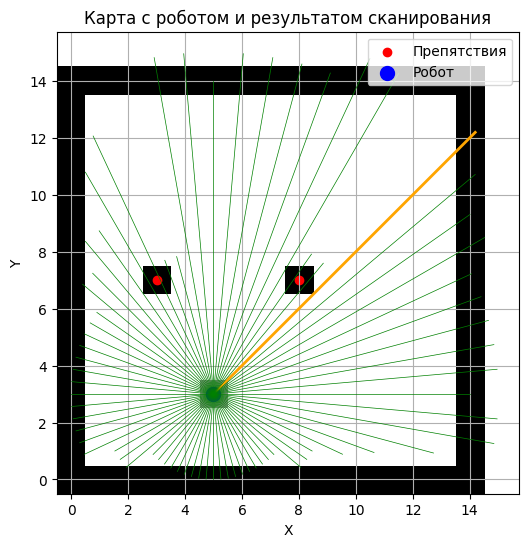

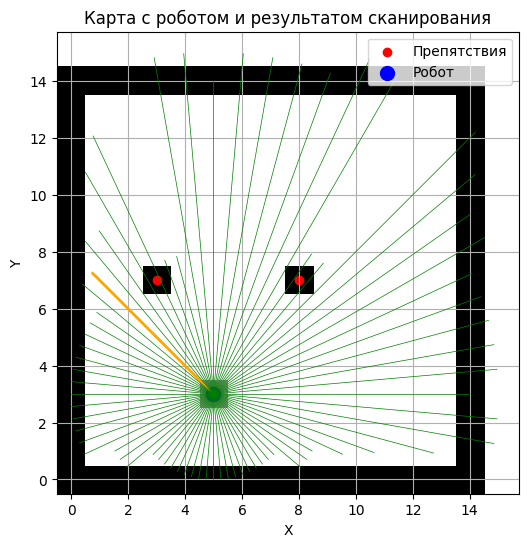

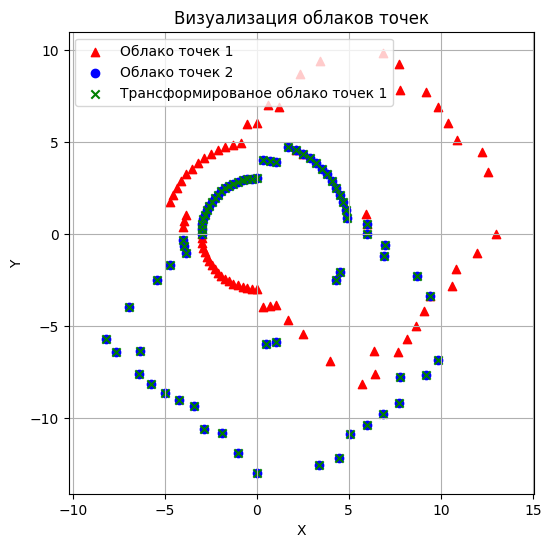

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=5, y=3, theta=0.7853981633974483) pose2=RobotPose(x=5, y=3, theta=2.356194490192345)
Точность трансформации ветора X/Y - 0.0%
 -- Истинное преобразвание -- 
	X	0
	Y	0
	θ(rad)	1.571
 -- Расчитанное преобразование -- 
	X	-0.0
	Y	-0.0
	θ(rad)	1.571
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.0 (0.0%)
	Y	0.0 (0.0%)
	θ(rad)	0.0 (0.0%) (% от 2*Pi)
  == Комната 2 - Эксперимент 4 ==  


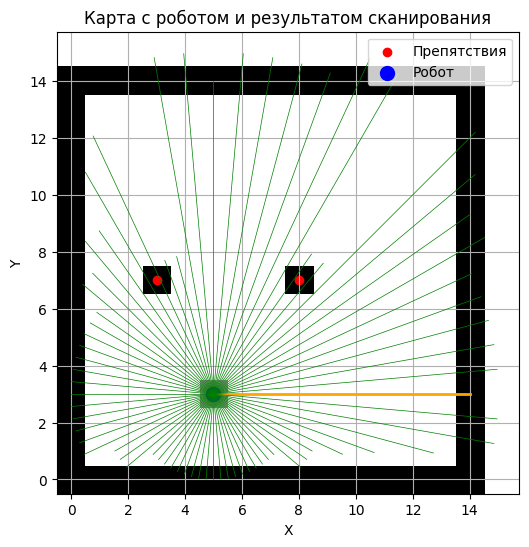

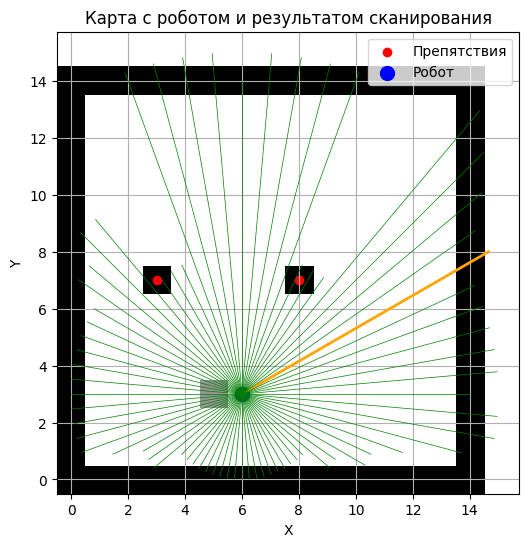

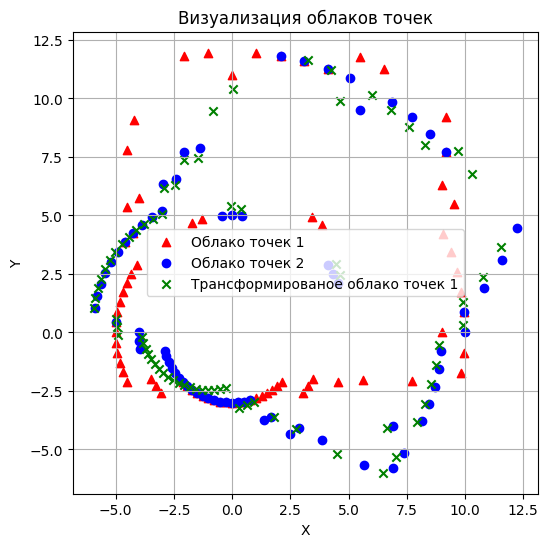

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=5, y=3, theta=0) pose2=RobotPose(x=6, y=3, theta=0.5235987755982988)
Точность трансформации ветора X/Y - 2.461%
 -- Истинное преобразвание -- 
	X	1
	Y	0
	θ(rad)	0.524
 -- Расчитанное преобразование -- 
	X	0.995
	Y	-0.522
	θ(rad)	0.541
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.005 (0.033%)
	Y	0.522 (3.48%)
	θ(rad)	0.018 (0.286%) (% от 2*Pi)
  == Комната 2 - Эксперимент 5 ==  


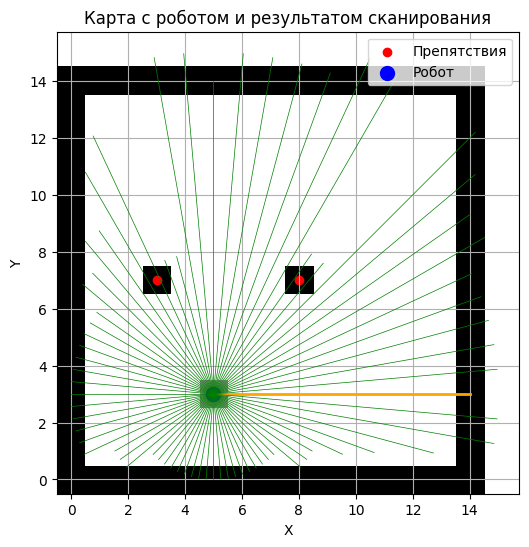

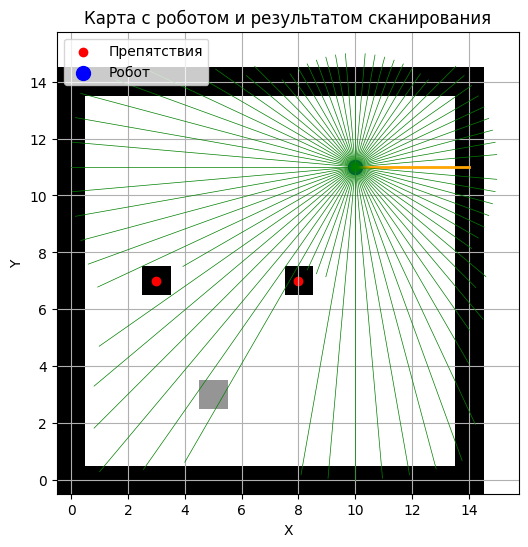

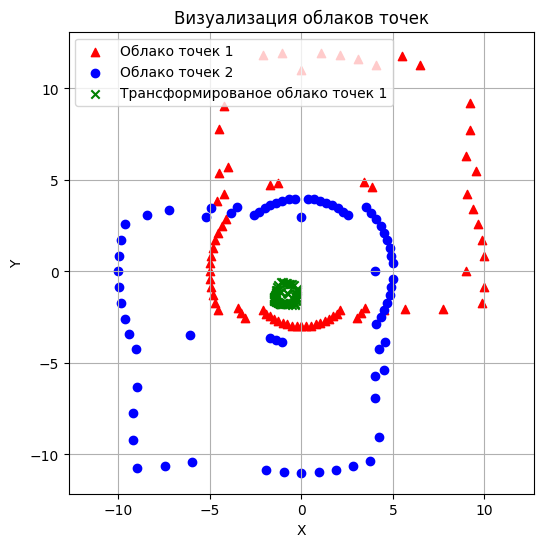

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=5, y=3, theta=0) pose2=RobotPose(x=10, y=11, theta=0)
Точность трансформации ветора X/Y - 35.596%
 -- Истинное преобразвание -- 
	X	5
	Y	8
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	1.106
	Y	1.531
	θ(rad)	0.193
 -- Разница преобразований (% от размера комнаты) -- 
	X	3.894 (25.96%)
	Y	6.469 (43.127%)
	θ(rad)	0.193 (3.072%) (% от 2*Pi)


In [8]:
for i, (pose1, pose2) in enumerate(room_test_setup2.robot_positions, start=1):
    print(f"  == Комната 2 - Эксперимент {i} ==  ")
    conduct_experiment(room_test_setup2.obstacle_positions, pose1, pose2)


  == Комната 3 - Эксперимент 1 ==  


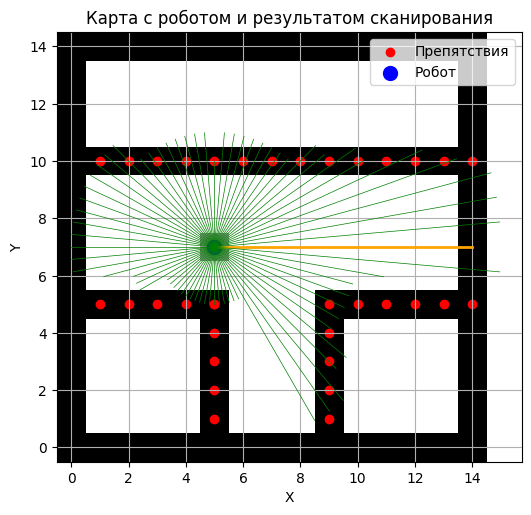

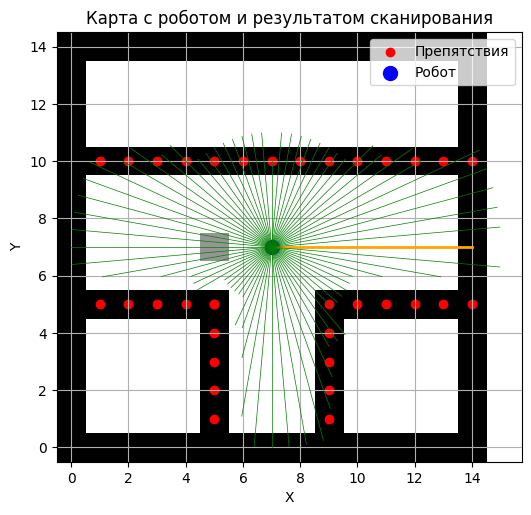

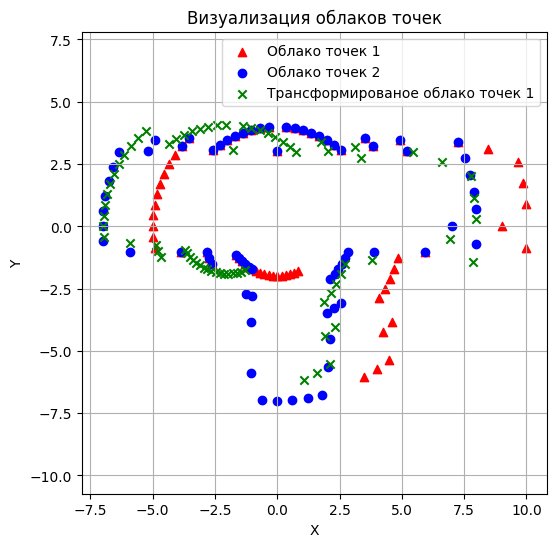

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=5, y=7, theta=0) pose2=RobotPose(x=7, y=7, theta=0)
Точность трансформации ветора X/Y - 0.405%
 -- Истинное преобразвание -- 
	X	2
	Y	0
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	1.996
	Y	-0.086
	θ(rad)	0.068
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.004 (0.027%)
	Y	0.086 (0.573%)
	θ(rad)	0.068 (1.082%) (% от 2*Pi)
  == Комната 3 - Эксперимент 2 ==  


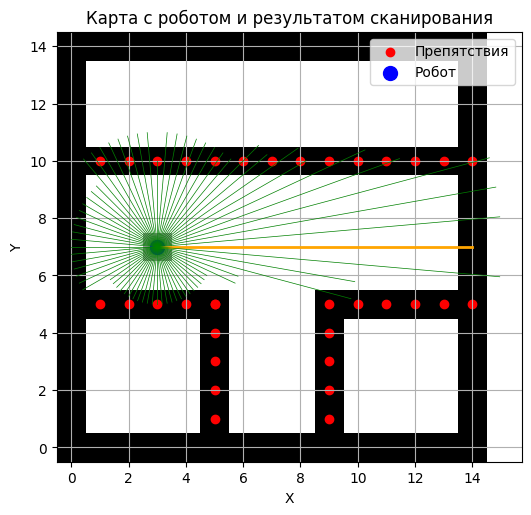

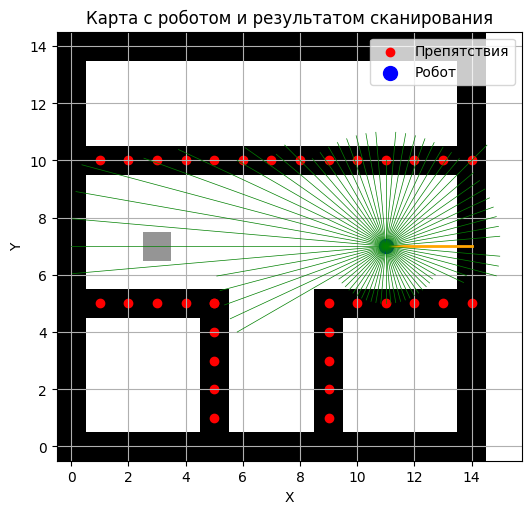

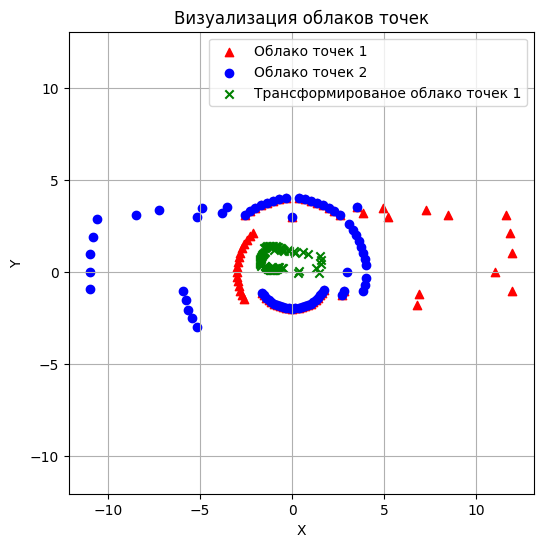

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=3, y=7, theta=0) pose2=RobotPose(x=11, y=7, theta=0)
Точность трансформации ветора X/Y - 32.697%
 -- Истинное преобразвание -- 
	X	8
	Y	0
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	1.085
	Y	-0.537
	θ(rad)	0.135
 -- Разница преобразований (% от размера комнаты) -- 
	X	6.915 (46.1%)
	Y	0.537 (3.58%)
	θ(rad)	0.135 (2.149%) (% от 2*Pi)
  == Комната 3 - Эксперимент 3 ==  


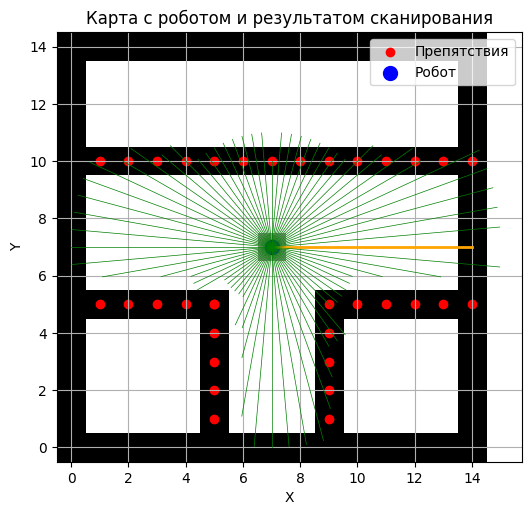

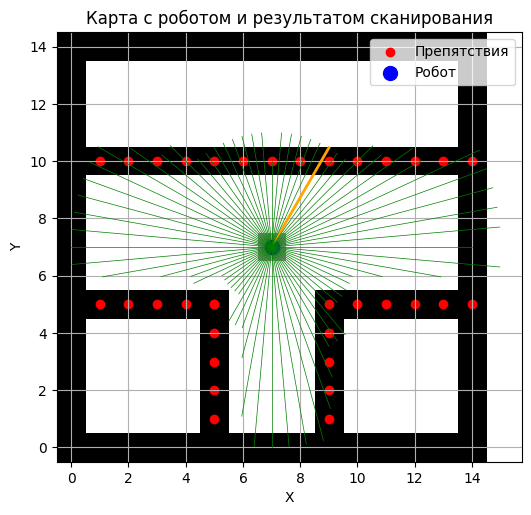

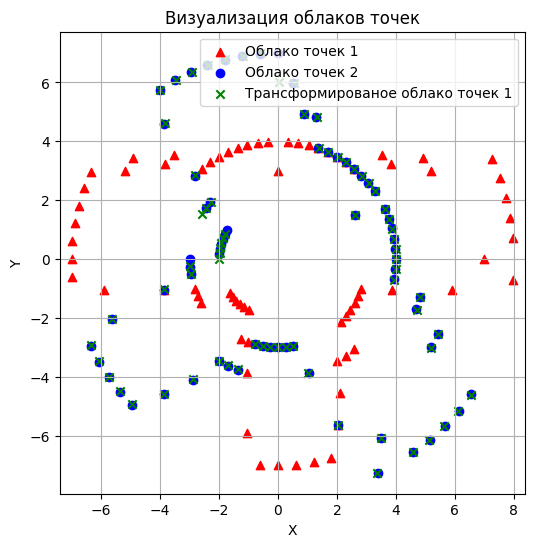

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=7, y=7, theta=0.0) pose2=RobotPose(x=7, y=7, theta=1.0471975511965976)
Точность трансформации ветора X/Y - 0.057%
 -- Истинное преобразвание -- 
	X	0
	Y	0
	θ(rad)	1.047
 -- Расчитанное преобразование -- 
	X	-0.01
	Y	-0.007
	θ(rad)	1.05
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.01 (0.067%)
	Y	0.007 (0.047%)
	θ(rad)	0.003 (0.048%) (% от 2*Pi)
  == Комната 3 - Эксперимент 4 ==  


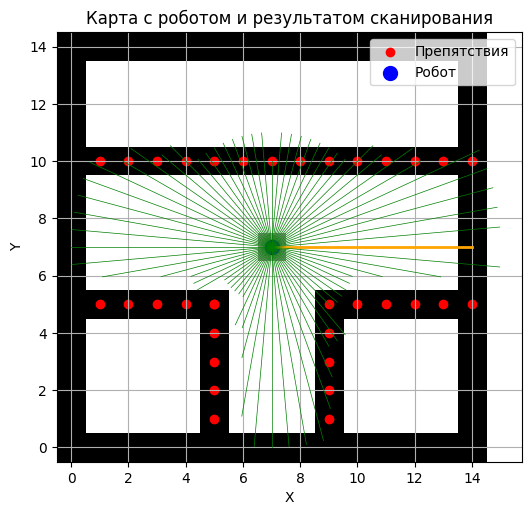

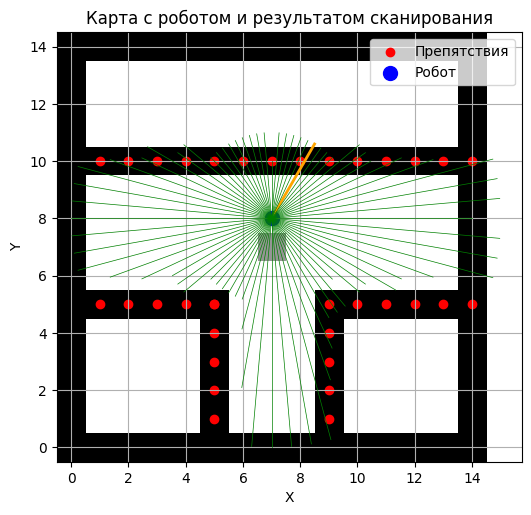

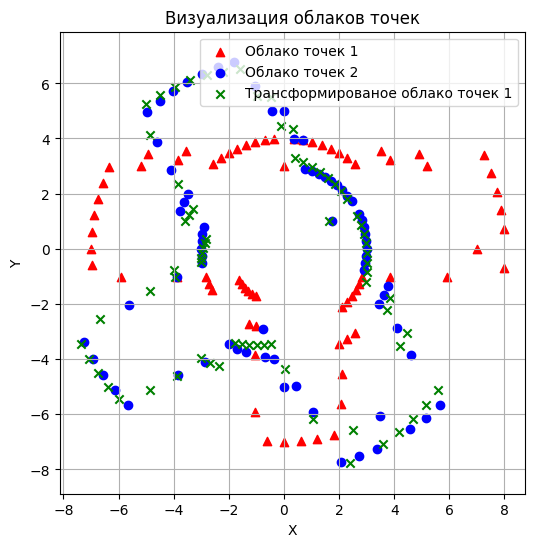

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=7, y=7, theta=0.0) pose2=RobotPose(x=7, y=8, theta=1.0471975511965976)
Точность трансформации ветора X/Y - 5.242%
 -- Истинное преобразвание -- 
	X	0
	Y	1
	θ(rad)	1.047
 -- Расчитанное преобразование -- 
	X	0.992
	Y	0.498
	θ(rad)	1.048
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.992 (6.613%)
	Y	0.502 (3.347%)
	θ(rad)	0.001 (0.016%) (% от 2*Pi)


In [9]:
for i, (pose1, pose2) in enumerate(room_test_setup3.robot_positions, start=1):
    print(f"  == Комната 3 - Эксперимент {i} ==  ")
    conduct_experiment(room_test_setup3.obstacle_positions, pose1, pose2)


  == Комната 4 - Эксперимент 1 ==  


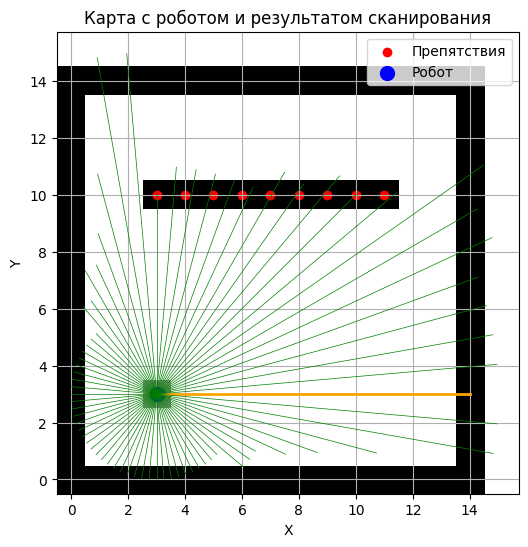

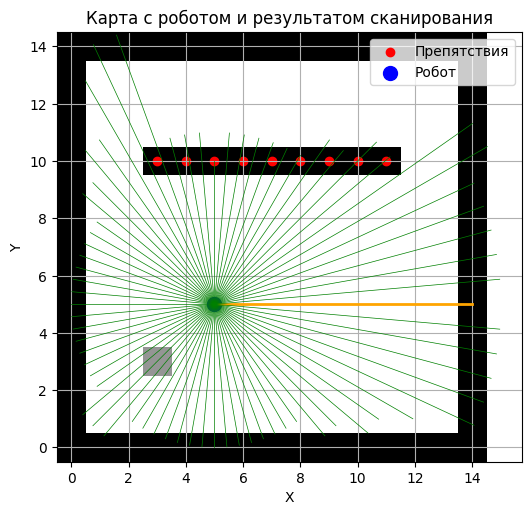

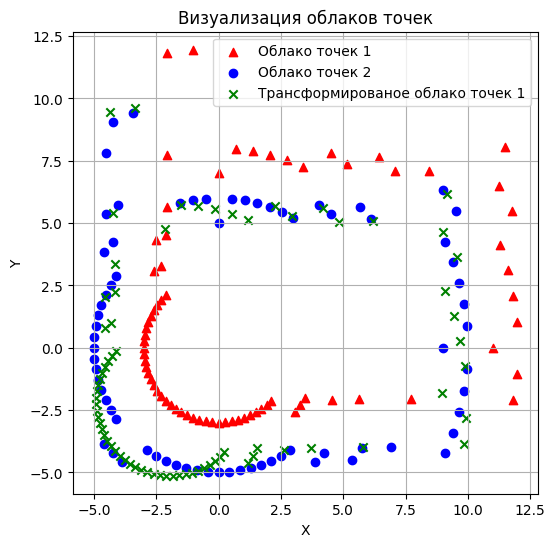

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=3, y=3, theta=0) pose2=RobotPose(x=5, y=5, theta=0)
Точность трансформации ветора X/Y - 0.853%
 -- Истинное преобразвание -- 
	X	2
	Y	2
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	1.932
	Y	2.168
	θ(rad)	-0.032
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.068 (0.453%)
	Y	0.168 (1.12%)
	θ(rad)	0.032 (0.509%) (% от 2*Pi)
  == Комната 4 - Эксперимент 2 ==  


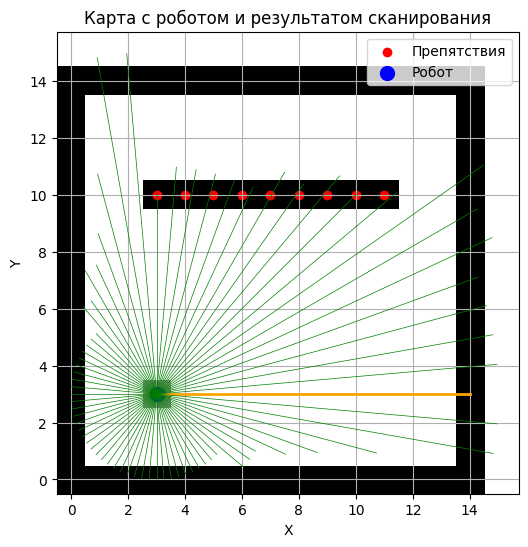

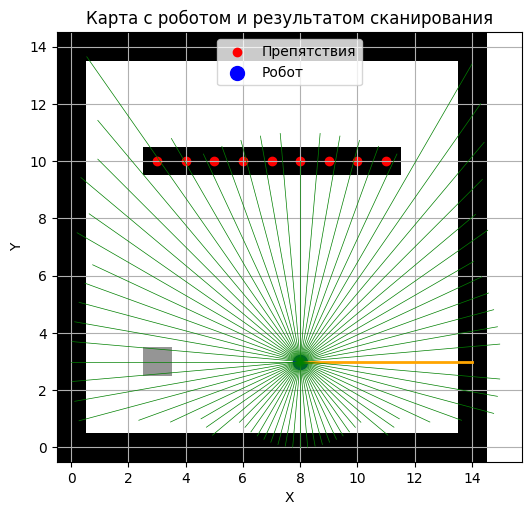

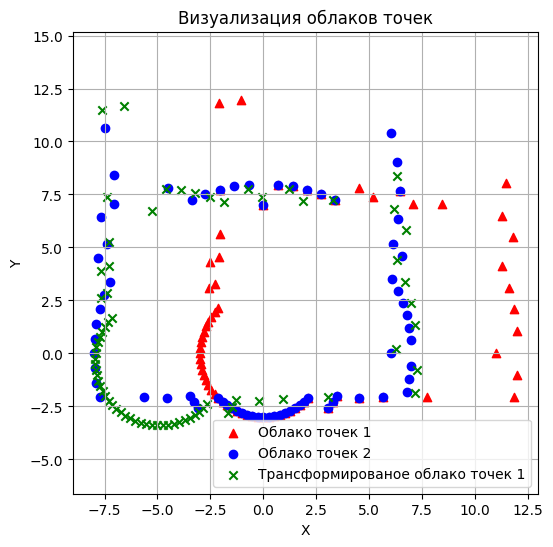

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=3, y=3, theta=0) pose2=RobotPose(x=8, y=3, theta=0)
Точность трансформации ветора X/Y - 1.749%
 -- Истинное преобразвание -- 
	X	5
	Y	0
	θ(rad)	0
 -- Расчитанное преобразование -- 
	X	4.902
	Y	0.358
	θ(rad)	-0.051
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.098 (0.653%)
	Y	0.358 (2.387%)
	θ(rad)	0.051 (0.812%) (% от 2*Pi)
  == Комната 4 - Эксперимент 3 ==  


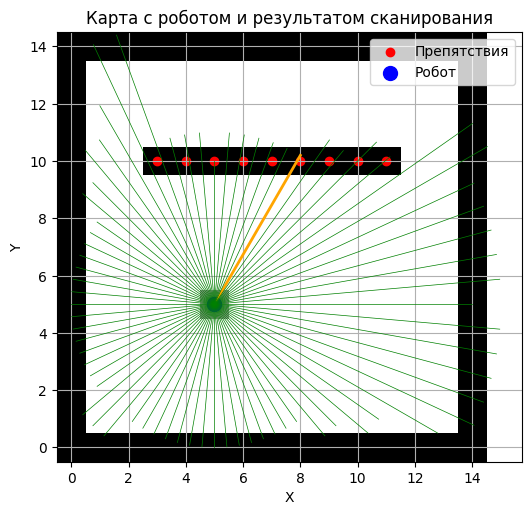

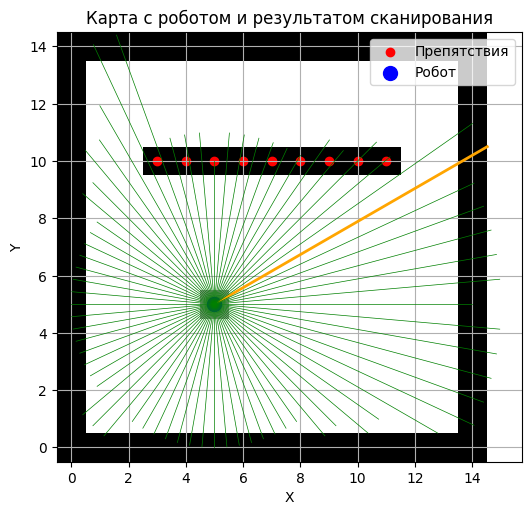

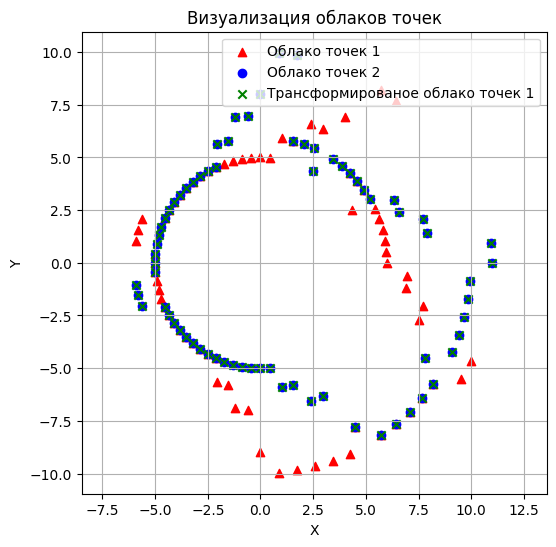

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=5, y=5, theta=1.0471975511965976) pose2=RobotPose(x=5, y=5, theta=0.5235987755982988)
Точность трансформации ветора X/Y - 0.0%
 -- Истинное преобразвание -- 
	X	0
	Y	0
	θ(rad)	-0.524
 -- Расчитанное преобразование -- 
	X	0.0
	Y	0.0
	θ(rad)	-0.524
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.0 (0.0%)
	Y	0.0 (0.0%)
	θ(rad)	0.0 (0.0%) (% от 2*Pi)
  == Комната 4 - Эксперимент 4 ==  


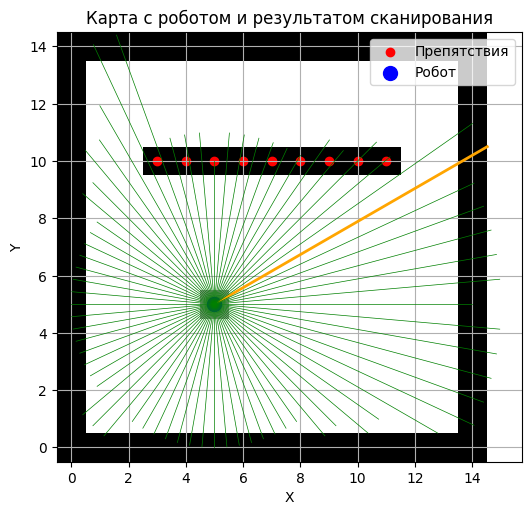

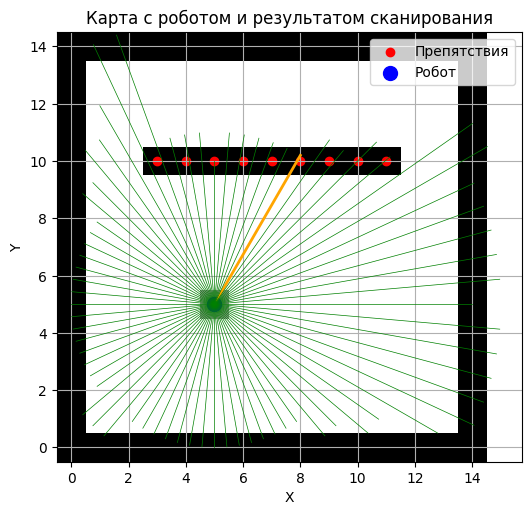

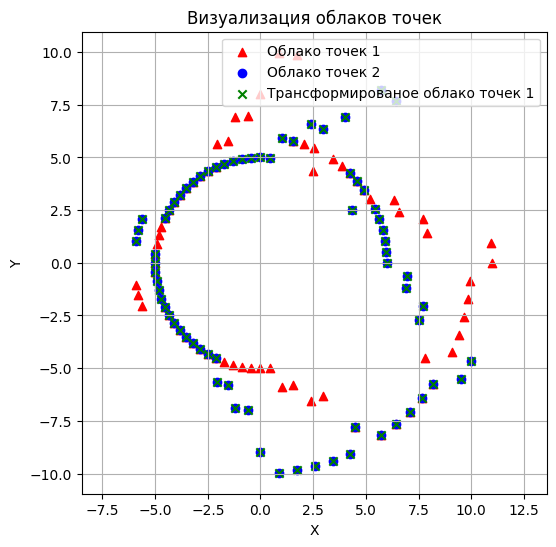

MAP_SIZE=15 LIDAR_ANGLE_STEP=5 pose1=RobotPose(x=5, y=5, theta=0.5235987755982988) pose2=RobotPose(x=5, y=5, theta=1.0471975511965976)
Точность трансформации ветора X/Y - 0.0%
 -- Истинное преобразвание -- 
	X	0
	Y	0
	θ(rad)	0.524
 -- Расчитанное преобразование -- 
	X	0.0
	Y	-0.0
	θ(rad)	0.524
 -- Разница преобразований (% от размера комнаты) -- 
	X	0.0 (0.0%)
	Y	0.0 (0.0%)
	θ(rad)	0.0 (0.0%) (% от 2*Pi)


In [10]:
for i, (pose1, pose2) in enumerate(room_test_setup4.robot_positions, start=1):
    print(f"  == Комната 4 - Эксперимент {i} ==  ")
    conduct_experiment(room_test_setup4.obstacle_positions, pose1, pose2)


# Итог

Реализованный scan matching обеспечивает приемлемую точность при небольших движениях (1 по X, 1 по Y, поворот на месте).

При одновременном перемещении X,Y и повороте точность падает.

Если закидывать робота в другую часть комнаты или поместить в комнату со сложным окружением - можно разочароваться в точности.

Погрешность поворота на месте (при повороте до 90 градусов) - около нуля.

Coherent Point Drift может работать с облаками точек разной размерности, что может быть удобным в ситуациях, когда максимальная длина скана ограничена.